### USHER: Aligning Xenium Spatial Transcriptomics to scRNA-seq using scGPT Embeddings

This notebook demonstrates how to use **USHER** (Unified Strategy for Shifting Towards Established Representations) to align out-of-distribution spatial transcriptomics data (Xenium) to a reference scRNA-seq dataset using foundation model embeddings from scGPT.

#### Overview

The key challenge is that Xenium spatial transcriptomics and scRNA-seq data remain misaligned due to differences between the modalities with scRNA-seq being in-distribution with scGPT training data and Xenium being out-of-distribution.

**USHER learns a linear transformation** that shifts the Xenium embeddings toward the scRNA-seq embedding distribution, enabling better integration of spatial and single-cell data and pave way for downstream analysis using the aligned representations.

#### Workflow
1. Load pre-computed scGPT embeddings for both datasets
2. Visualize the initial embedding distributions (showing misalignment)
3. Run USHER alignment using Fused Gromov-Wasserstein optimal transport
4. Evaluate the aligned embeddings

## Setup and Imports

In [2]:
%load_ext autoreload
%autoreload 2


In [3]:
import scanpy as sc
import rapids_singlecell as rsc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import anndata as ad
print(f"rapids-singlecell: {rsc.__version__}\n"
      f"scanpy: {sc.__version__}\n"
      f"pandas: {pd.__version__}\n"
      f"numpy: {np.__version__}\n"
      f"seaborn: {sns.__version__}\n"
      f"anndata: {ad.__version__}")

2025-12-15 11:52:38.778122: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765817558.795034   86937 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765817558.800102   86937 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765817558.820331   86937 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765817558.820376   86937 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765817558.820380   86937 computation_placer.cc:177] computation placer alr

rapids-singlecell: 0.11.1
scanpy: 1.10.4
pandas: 2.2.2
numpy: 1.26.0
seaborn: 0.13.2
anndata: 0.11.3


#### Data available from here:
https://drive.google.com/drive/folders/1U_VW--4BaTaxVQdYLuU1wOwg7aUQmkRU 
Download datasets from here and unpack into datasets/ directory. These files contain precomputed scGPT embeddings in 'adata.obsm['scGPT']'


## Load Datasets

We load two AnnData objects containing pre-computed scGPT embeddings:
- **xenium_scGPT.h5ad**: Xenium spatial transcriptomics data (~38K cells, 342 genes)
- **scRNAseq_scGPT.h5ad**: Reference scRNA-seq data (~26K cells, 25K genes)

Both files contain scGPT embeddings stored in `adata.obsm['X_scGPT']`.

In [6]:
xenAD = sc.read_h5ad('../datasets/xenium_scGPT.h5ad')

scAD = sc.read_h5ad('../datasets/scRNAseq_scGPT.h5ad')


In [7]:
xenAD

AnnData object with n_obs × n_vars = 38280 × 342
    obs: 'sample', 'patient', 'cell_id', 'full_cell_id', 'sample_type', 'sample_affect', 'disease_status', 'percent_pathology', 'tma', 'run', 'final_CT', 'final_lineage', 'CNiche', 'TNiche', 'lumen_id', 'lumen_rank', 'x_centroid', 'y_centroid', 'adj_x_centroid', 'adj_y_centroid', 'super_adj_x_centroid', 'super_adj_y_centroid', 'nCount_RNA', 'nFeature_RNA', 'perc_negcontrolprobe', 'perc_negcontrolcodeword', 'perc_unassigned', 'perc_negcontrolorunassigned', 'nCount_niche', 'nFeature_niche', 'assay', 'sID', 'predicted_celltype'
    var: 'mean', 'std', 'gene_id', 'n_counts', 'index', 'id_in_vocab'
    uns: 'log1p'
    obsm: 'X_SP', 'X_celltype_probs', 'X_pca', 'X_scGPT', 'X_sp', 'X_umap', 'bin_edges'
    varm: 'PCs'
    layers: 'X_binned', 'X_log1p', 'X_normed'

In [8]:
scAD

AnnData object with n_obs × n_vars = 26323 × 25425
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'Sample_Name', 'Diagnosis', 'Sample_Source', 'Sample_Type', 'Tobacco', 'Status', 'Flowcell_ID', 'Processing_site', 'Gender', 'Age', 'Ethnicity', 'S.Score', 'G2M.Score', 'Phase', 'nCount_SCT', 'nFeature_SCT', 'Short_Sample_Name', 'manual_annotation_1', 'annotation_level_1', 'annotation_level_2', 'lineage', 'assay', 'annotation_level_0', 'sID'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'gene_id', 'n_counts', 'index', 'id_in_vocab'
    uns: 'annotation_level_0_colors', 'log1p', 'neighbors', 'umap'
    obsm: 'X_celltype_probs', 'X_scGPT', 'X_umap', 'bin_edges'
    layers: 'X_binned', 'X_log1p', 'X_normed'
    obsp: 'connectivities', 'distances'

## Data Exploration

Let's examine the key difference between the two modalities: **gene coverage**. Xenium captures only ~300 genes while scRNA-seq measures ~25,000 genes per cell. This fundamental difference in input data creates challenges for foundation model embeddings.

Text(0.5, 1.0, '\n Xenium')

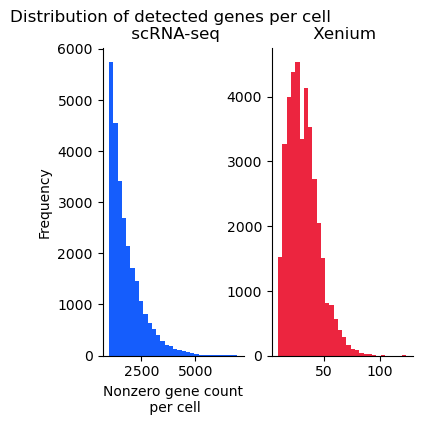

In [9]:

fig, ax = plt.subplots(1, 2, figsize=(4, 4))

counts, bins, _ = ax[1].hist((xenAD.X != 0).sum(axis=1), bins=30, color="#EC253F")

counts, bins, _ = ax[0].hist((scAD.X != 0).sum(axis=1), bins=30, color="#155DFC")
ax[0].set_xlabel("Nonzero gene count\n per cell")
ax[0].set_ylabel("Frequency")
ax[1].set_xlabel("")
ax[1].set_ylabel("")
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[0].set_title("Distribution of detected genes per cell \n scRNA-seq")
ax[1].set_title("\n Xenium")



## Prepare scGPT Embedding AnnData Objects

We create new AnnData objects where the main matrix `X` contains the scGPT embeddings (512 dimensions). This allows us to use standard scanpy/rapids-singlecell functions for downstream analysis.

In [10]:
xenAD_scGPT = ad.AnnData(X= xenAD.obsm['X_scGPT'], obs= xenAD.obs, obsm=xenAD.obsm)
xenAD_scGPT.obs['assay'] = 'Xenium'
xenAD_scGPT.obs['cell_type'] = xenAD.obs['predicted_celltype']
scAD_scGPT = ad.AnnData(X= scAD.obsm['X_scGPT'], obs= scAD.obs, obsm=scAD.obsm)
scAD_scGPT.obs['assay'] = 'scRNA-seq'
scAD_scGPT.obs['cell_type'] = scAD.obs['annotation_level_0']

combinedAD = ad.concat([xenAD_scGPT, scAD_scGPT], axis=0, label='batch')

## Compute UMAP Embeddings

We compute neighbor graphs and UMAP embeddings using **cosine distance** (which scGPT embeddings are optimized for) to visualize the embedding spaces.

In [11]:
rsc.pp.neighbors(xenAD_scGPT, use_rep='X', metric='cosine')
rsc.pp.neighbors(scAD_scGPT, use_rep='X', metric='cosine')
rsc.pp.neighbors(combinedAD, use_rep='X', metric='cosine')
rsc.tl.umap(xenAD_scGPT)
rsc.tl.umap(scAD_scGPT)
rsc.tl.umap(combinedAD)

In [13]:
ctype_palette = sc.pl.palettes.default_20
ctype_colors = {ct: c for ct, c in zip(sorted(combinedAD.obs['cell_type'].unique()), ctype_palette)}
assay_colors = {'Xenium': '#EC253F', 'scRNA-seq':'#155DFC'}

In [14]:
ctype_palette = sc.pl.palettes.default_20
ctype_colors = {ct: c for ct, c in zip(sorted(combinedAD.obs['cell_type'].unique()), ctype_palette)}
assay_colors = {'Xenium': '#EC253F', 'scRNA-seq':'#155DFC'}

Text(0.5, 1.0, 'Cell type')

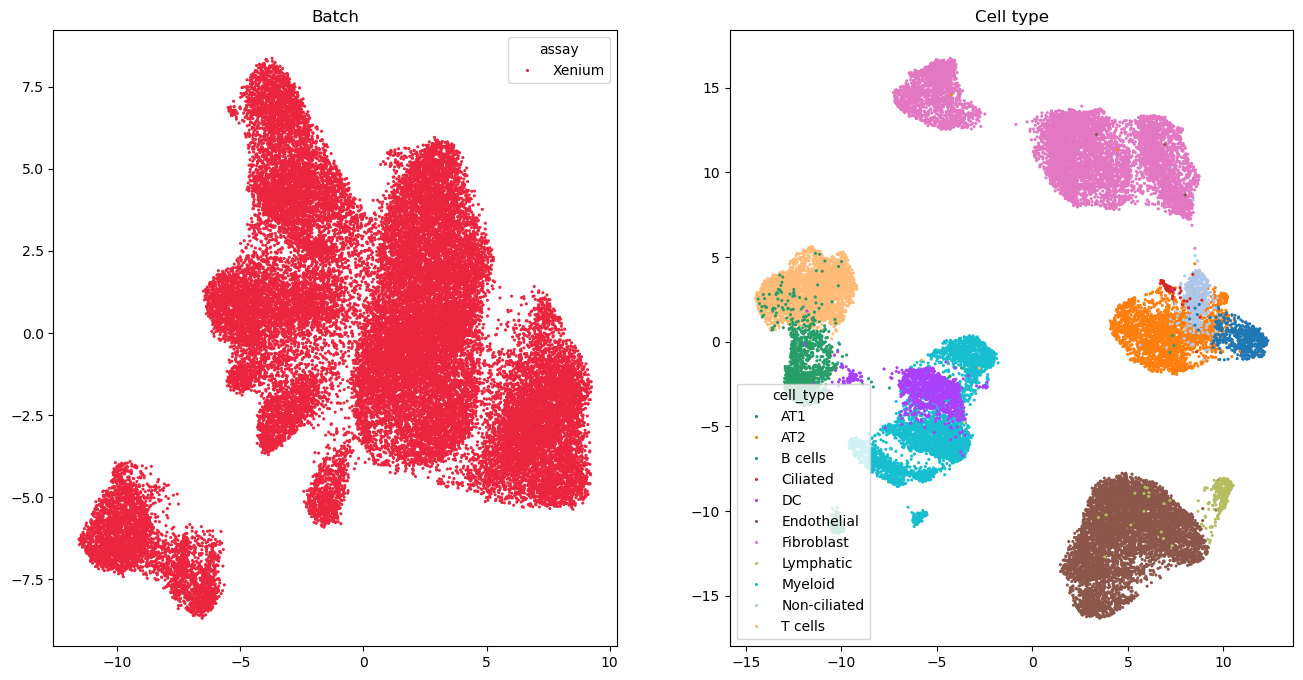

In [15]:


fig, ax = plt.subplots(1, 2, figsize=(16, 8))

sns.scatterplot(x=xenAD_scGPT.obsm['X_umap'][:, 0], y=xenAD_scGPT.obsm['X_umap'][:, 1], hue=xenAD_scGPT.obs['assay'], palette=assay_colors, s=5, linewidth=0, ax=ax[0])
sns.scatterplot(x=scAD_scGPT.obsm['X_umap'][:, 0], y=scAD_scGPT.obsm['X_umap'][:, 1], hue=scAD_scGPT.obs['cell_type'], palette=ctype_colors, s=5, linewidth=0, ax=ax[1])

ax[0].set_title('Batch')
ax[1].set_title('Cell type')





Text(0.5, 1.0, 'Cell type')

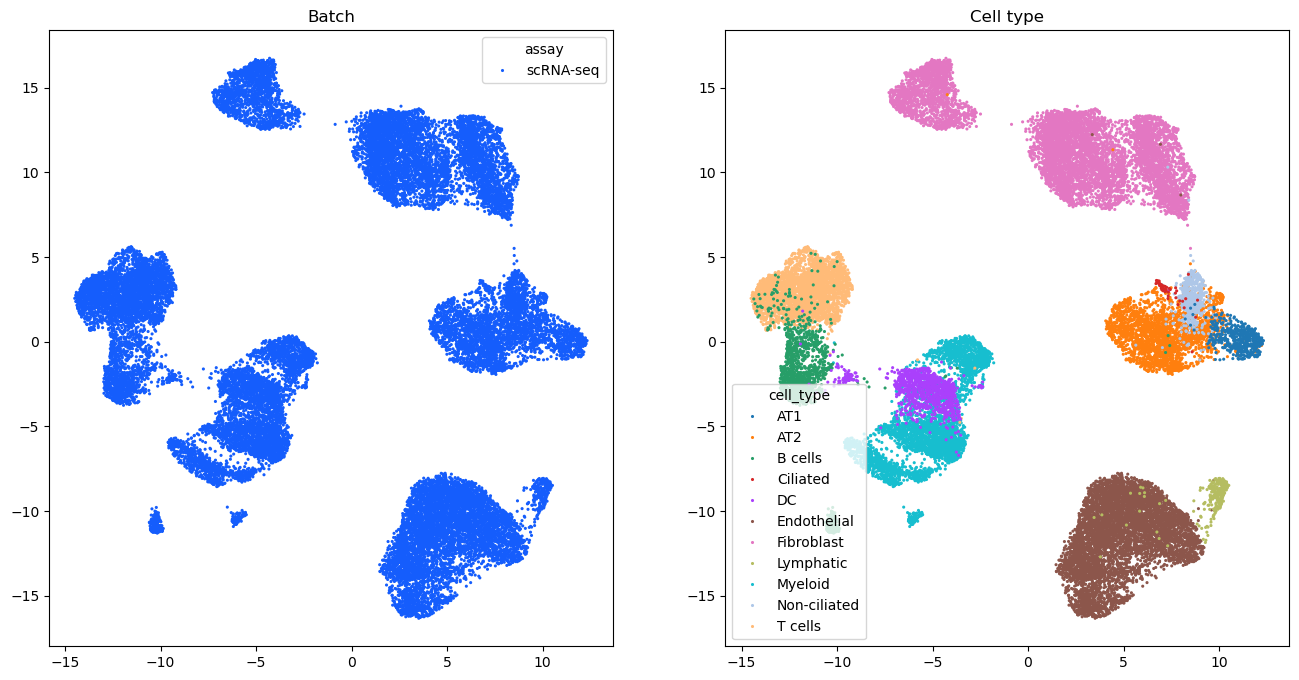

In [16]:


fig, ax = plt.subplots(1, 2, figsize=(16, 8))

sns.scatterplot(x=scAD_scGPT.obsm['X_umap'][:, 0], y=scAD_scGPT.obsm['X_umap'][:, 1], hue=scAD_scGPT.obs['assay'], palette=assay_colors, s=5, linewidth=0, ax=ax[0])
sns.scatterplot(x=scAD_scGPT.obsm['X_umap'][:, 0], y=scAD_scGPT.obsm['X_umap'][:, 1], hue=scAD_scGPT.obs['cell_type'], palette=ctype_colors, s=5, linewidth=0, ax=ax[1])

ax[0].set_title('Batch')
ax[1].set_title('Cell type')



Text(0.5, 1.0, 'Cell type')

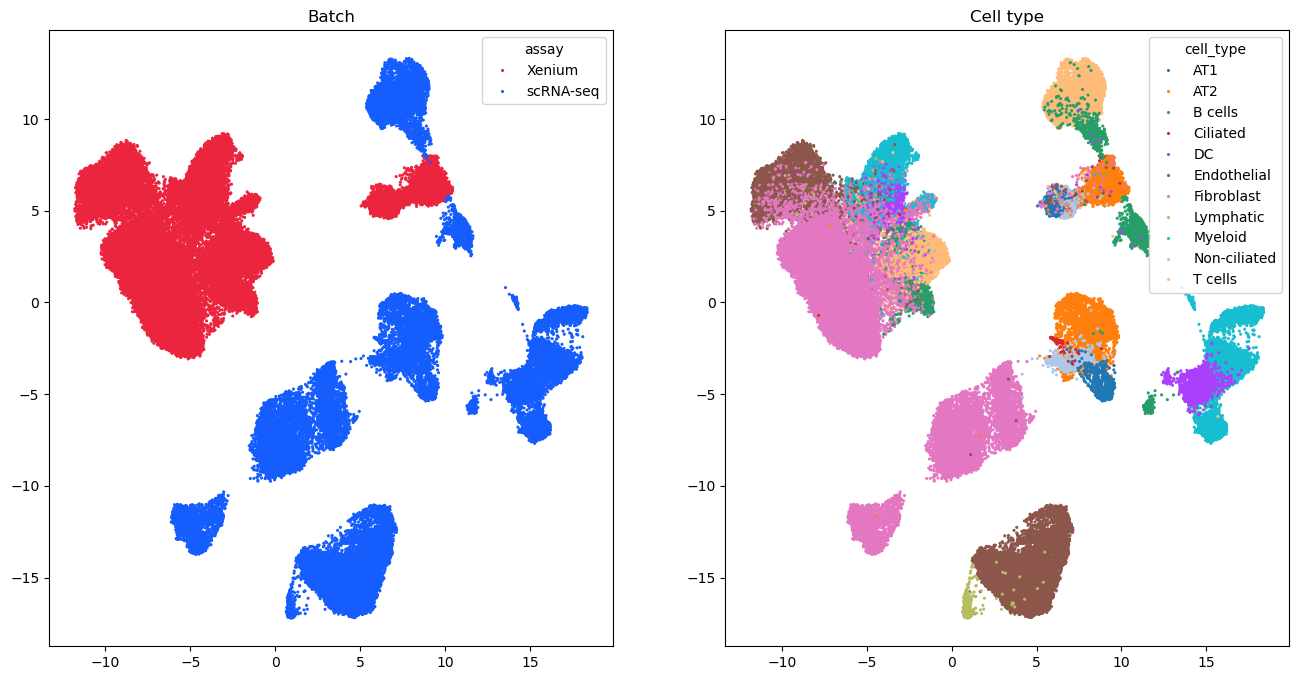

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

sns.scatterplot(x=combinedAD.obsm['X_umap'][:, 0], y=combinedAD.obsm['X_umap'][:, 1], hue=combinedAD.obs['assay'], palette=assay_colors, s=5, linewidth=0, ax=ax[0])
sns.scatterplot(x=combinedAD.obsm['X_umap'][:, 0], y=combinedAD.obsm['X_umap'][:, 1], hue=combinedAD.obs['cell_type'], palette=ctype_colors, s=5, linewidth=0, ax=ax[1])

ax[0].set_title('Batch')
ax[1].set_title('Cell type')


In [18]:
import sys
sys.path.append('../src/')

from run_usher import align_features_fgw


model, mapping_final, concat_adata, T_full, scaler_mean, scaler_std = align_features_fgw(
    xenAD_scGPT.copy(),
    scAD_scGPT.copy(),
    e_step_method="fgw",
    alpha=0.3, 
    lambda_cross=0.9,
    lambda_var=0.1,
    cell_type_col="cell_type",
    celltype_probs_layer="X_celltype_probs",
    sketch_size=4300,
    knn_k=30,
    metric="cosine",
    m_step_metric="euclidean",
    gamma=0.,
    epsilon=0.05,
    use_linear_assignment=True,
    sinkhorn_iters=1000,
    n_iters=10,
    steps_per_iter=100,
    lr=1e-3,
    hidden_dim=512,
    debug_plots_path="../datasets/scGPT_example/",)



In [ ]:
model, mapping_final, concat_adata, T_full, scaler_mean, scaler_std = align_features_fgw(
    xenAD_scGPT.copy(),
    scAD_scGPT.copy(),
    e_step_method="fgw",
    alpha=0.3, 
    lambda_cross=0.9,
    lambda_var=0.1,
    cell_type_col="cell_type",
    celltype_probs_layer="X_celltype_probs",
    sketch_size=4300,
    knn_k=30,
    metric="cosine",
    m_step_metric="euclidean",
    gamma=0.,
    epsilon=0.05,
    use_linear_assignment=True,
    sinkhorn_iters=1000,
    n_iters=10,
    steps_per_iter=100,
    lr=1e-3,
    hidden_dim=512,
    debug_plots_path="../datasets/scGPT_example/",)



### Load a Saved USHER Model
You can reload a previously trained alignment model for downstream analysis or application to new data.
 Here, we load a saved USHER model from the `datasets/scGPT_example/` directory.
 Make sure the path matches the location where the model was saved after training.


In [21]:
#load learned transformation
from model_utils import *
model, scaler_mean,scaler_std, gene_names = load_alignment_model('../datasets/scGPT_example/alignment_model.pt', hidden_dim=512)

2025-12-15 11:55:41,390 - INFO - Model loaded from ../datasets/scGPT_example/alignment_model.pt to cuda (with feature scaler)


In [22]:
xenAD_scGPT_aligned = xenAD_scGPT.copy()

In [23]:
import torch
# Load and convert data
from model_utils import _to_dense_float32
X_new = _to_dense_float32(xenAD_scGPT_aligned.X)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
X_new = torch.from_numpy(X_new).to(device)
from m_step_utils import standardize_features, unstandardize_features
X_new_std = standardize_features(X_new, scaler_mean, scaler_std)

features_new = X_new_std.to(device)
with torch.no_grad():
    features_transformed = model(features_new)
features_transformed = unstandardize_features(features_transformed, scaler_mean, scaler_std)
xenAD_scGPT_aligned = ad.AnnData(X=features_transformed.detach().cpu().numpy(), obs=xenAD_scGPT_aligned.obs,obsm=xenAD_scGPT_aligned.obsm)

In [27]:
combinedAD_aligned = ad.concat([xenAD_scGPT_aligned, scAD_scGPT], axis=0, label='batch')

In [28]:
rsc.pp.neighbors(combinedAD_aligned, use_rep='X', metric='cosine')
rsc.tl.umap(combinedAD_aligned)


Text(0.5, 1.0, 'Cell type')

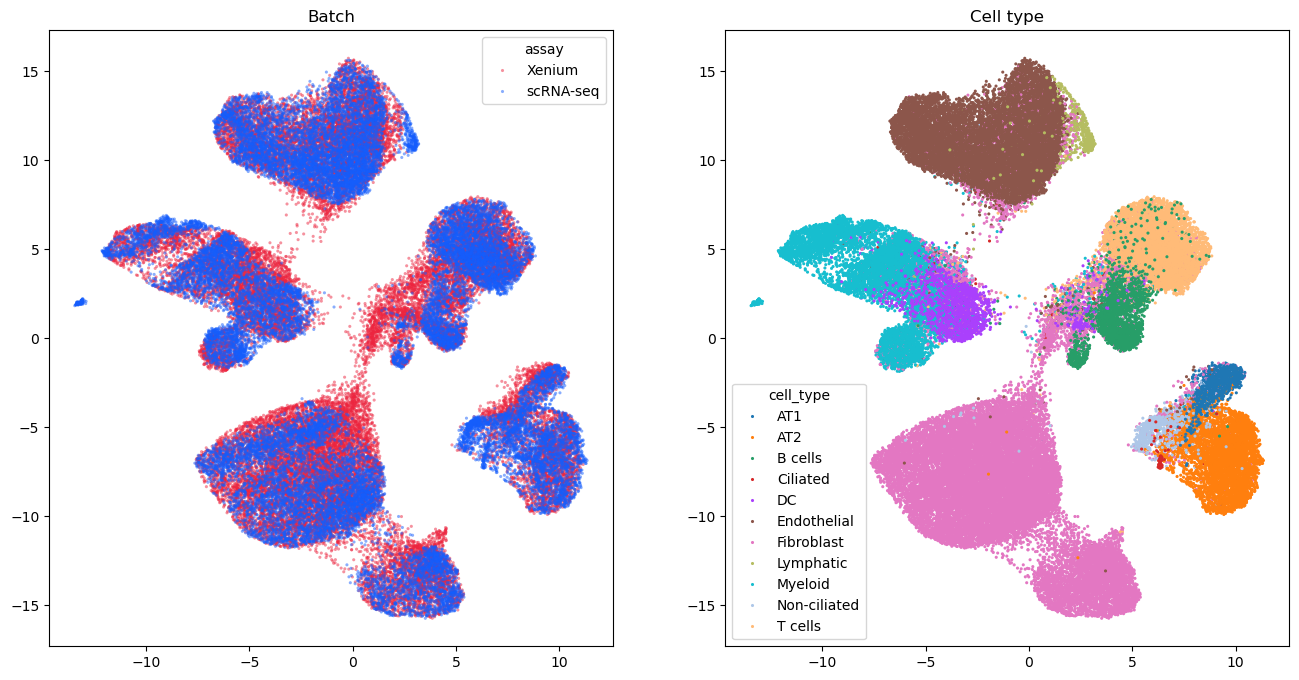

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

sns.scatterplot(x=combinedAD_aligned.obsm['X_umap'][:, 0], y=combinedAD_aligned.obsm['X_umap'][:, 1], hue=combinedAD_aligned.obs['assay'], palette=assay_colors, s=5, linewidth=0, ax=ax[0], alpha=0.5)
sns.scatterplot(x=combinedAD_aligned.obsm['X_umap'][:, 0], y=combinedAD_aligned.obsm['X_umap'][:, 1], hue=combinedAD_aligned.obs['cell_type'], palette=ctype_colors, s=5, linewidth=0, ax=ax[1])

ax[0].set_title('Batch')
ax[1].set_title('Cell type')
